<a href="https://colab.research.google.com/github/achmfirmansyah/sweet_project/blob/master/Geopython-PythonMachineLearning2020/02_Builtup_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of built-up area
After data is prepared from previous notebook, here is the code for conducting classification using XGBoost



## Preparation
### Import the package used

In [ ]:
import pandas as pd
!pip install rasterio
import rasterio
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
!pip install xgboost
import xgboost as xgb
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Open the data and preprocessing the data
Here i open the data using the rasterio package and preprocessing the data as follow:
1. calculate the LSE [Land Surface Emmisivity] from NDVI indices 
2. classify the built up class from GHSL into binary data (built up and non built up)
3. sampling the data (to speed up the process) 
4. perform min max scaling
5. split sampling data into train (80%) and test (20%) by stratiied shuffle data for cross validation

In [ ]:
dataset = rasterio.open('/content/gdrive/My Drive/GeoPythonML_/compiled_GHSL_30_2014_.tif')
dataset_bands=pd.DataFrame()
# iterate the bands from imagery and fill them into dataframe
for i in dataset.indexes:
    temp=dataset.read(i)
    temp=pd.DataFrame(data=np.array(temp).flatten()).rename(columns={0:i})
    dataset_bands=temp.join(dataset_bands)
# rename the columns
dataset_bands.rename(columns={1:'BU_class',2:'NDVI_landsat8',3:'NDBI_landsat8',4:'MNDWI_landsat8',
                            5:'SAVI_landsat8',6:'rad_VIIRS'},inplace=True)
# LSE calculation from NDVI using Van de Griend and Owe Formula
dataset_bands['LSE_der_landsat8']=dataset_bands.NDVI_landsat8.apply(lambda y: 0.995 if y < -0.185 else (
    0.970 if y< 0.157 else (1.0098+0.047*np.log(y) if y<0.727 else 0.990)))
# Classify the built up into binary data
dataset_bands['U_class']=dataset_bands.BU_class.apply(lambda y: 1 if y>=3 else 0)
# sampling the data 
dataset=dataset_bands.query('U_class==0').sample(10000).append(dataset_bands.query('U_class==1').sample(10000))
dataset=dataset.reset_index()[['rad_VIIRS','SAVI_landsat8','MNDWI_landsat8','NDBI_landsat8','NDVI_landsat8','LSE_der_landsat8','U_class']]
# scaling data using minmax scaling
minmax_=preprocessing.MinMaxScaler()
X=minmax_.fit_transform(dataset[['rad_VIIRS','SAVI_landsat8','NDVI_landsat8','MNDWI_landsat8','NDBI_landsat8','LSE_der_landsat8']])
y=dataset[['U_class']]
# stratified shuffe split
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

## XGBoost Classification
### Parameter Tuning with GridSearch 
Next is performing classification. In XGBoost, several paramater is used, such as learning rate, number of estimator, max depth, objective functaion and soon. Here i tune the learning rate, number of estimator, and max depth from the range that i define.

In [ ]:
# define the parameter range
parameters = {'nthread':[4], 
              'objective':['binary:logistic'],
              'learning_rate': [0.1,0.07,0.04], #so called `eta` value
              'max_depth': [3,4,5,6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [100,200,500,1000], #number of trees, change it to 1000 for better results
              'seed': [123]}
# define the classifier
xgclassifier = xgb.XGBClassifier()
# run the gridsearch 

scoring = {'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'F1':'f1'}
grid = GridSearchCV(xgclassifier, param_grid=parameters, cv=cv, scoring=scoring, refit='AUC',return_train_score=True)
grid.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=N...
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.07, 0.04],
                         'max_depth': [3, 4, 5, 6], 'min_child_weight': [11],
                         'n_estimators': [100, 200, 500, 1000], 'nthread': [4],
                         'objective': ['binary:logistic'], 'seed': [123],
                       

### Visualize the GridSearch Result
Here is the code for visualize the result of grid search process

In [ ]:
params_grid=grid.cv_results_['params']
test_AUC=grid.cv_results_['mean_test_AUC']
test_Accuracy=grid.cv_results_['mean_test_Accuracy']
test_F1=grid.cv_results_['mean_test_F1']
train_AUC=grid.cv_results_['mean_train_AUC']
train_Accuracy=grid.cv_results_['mean_train_Accuracy']
train_F1=grid.cv_results_['mean_train_F1']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
scoring_=pd.DataFrame({'test_AUC':test_AUC,'test_Acc':test_Accuracy,'test_F1':test_F1,'train_AUC':train_AUC,'train_Acc':train_Accuracy,'train_F1':train_F1},
             columns=['test_AUC','test_Acc','test_F1','train_AUC','train_Acc','train_F1']).reset_index().rename(columns={'index':'Index_params'})

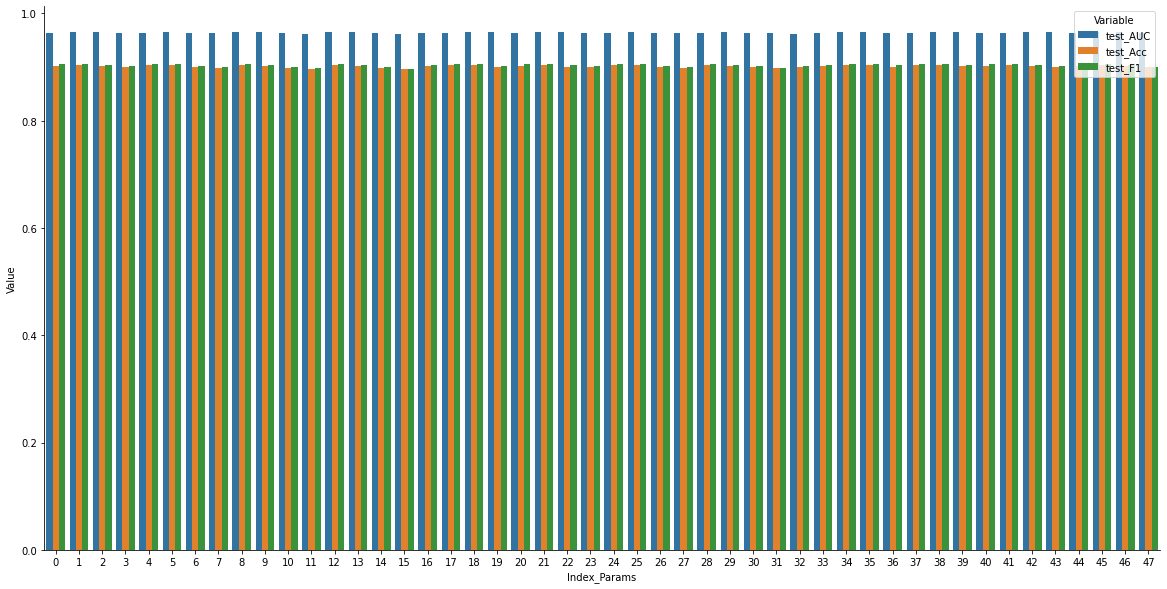

In [ ]:
fig, ax1 = plt.subplots(figsize=(20, 10))
tidy = scoring_[['Index_params','test_AUC','test_Acc','test_F1']].melt(id_vars='Index_params').rename(columns=str.title)
sns.barplot(x='Index_Params', y='Value', hue='Variable', data=tidy, ax=ax1)
sns.despine(fig)

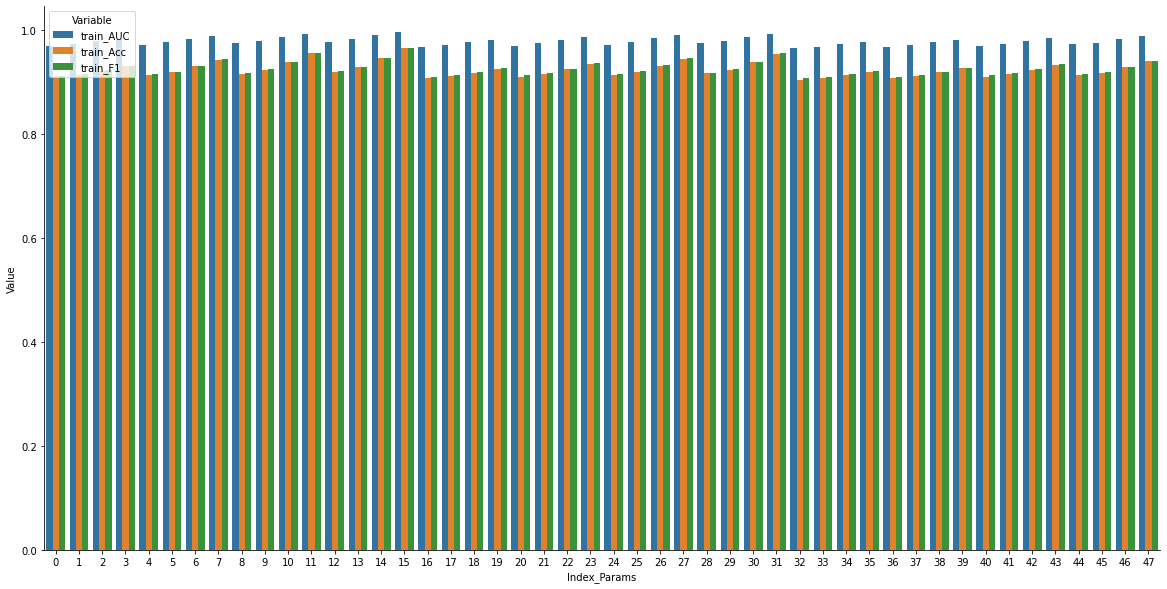

In [ ]:
fig, ax1 = plt.subplots(figsize=(20, 10))
tidy = scoring_[['Index_params','train_AUC','train_Acc','train_F1']].melt(id_vars='Index_params').rename(columns=str.title)
sns.barplot(x='Index_Params', y='Value', hue='Variable', data=tidy, ax=ax1)
sns.despine(fig)

**The Best Parameters**

In [ ]:
grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.04,
 'max_depth': 4,
 'min_child_weight': 11,
 'n_estimators': 500,
 'nthread': 4,
 'objective': 'binary:logistic',
 'seed': 123,
 'silent': 1,
 'subsample': 0.8}

In [ ]:
grid.best_score_

0.9648822375

### Run the Classifiers with best Parameters

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
dataset_scaled=minmax_.fit_transform(dataset[['rad_VIIRS','SAVI_landsat8','NDVI_landsat8','MNDWI_landsat8','NDBI_landsat8','LSE_der_landsat8']])
X_train, X_test, y_train, y_test = train_test_split(dataset_scaled,dataset[['U_class']], test_size = 0.20)
xgclassifier = xgb.XGBClassifier(random_state=123,colsample_bytree= 0.7, learning_rate=0.04, max_depth= 5, 
                             min_child_weight=11, n_estimators= 500, nthread= 4, objective= 'binary:logistic', 
                             seed= 123, silent=1, subsample= 0.8)
xgclassifier.fit(X_train,y_train)
y_pred=xgclassifier.predict(X_test)
print('Confussion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification report:')
print(classification_report(y_test, y_pred))

Confussion Matrix:
[[1819  232]
 [ 131 1818]]
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2051
           1       0.89      0.93      0.91      1949

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



#### XGBoost Tree

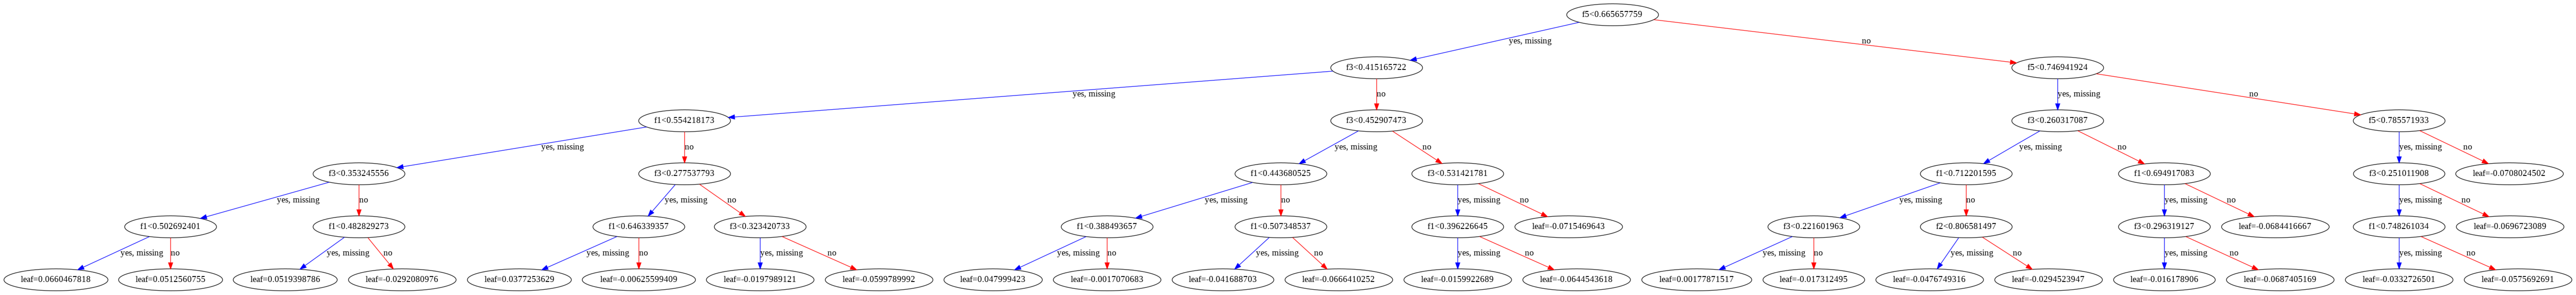

In [ ]:
fig, ax = plt.subplots(figsize=(200, 50))
xgb.plot_tree(xgclassifier,num_trees=3,ax=ax)

#### Feature Importance

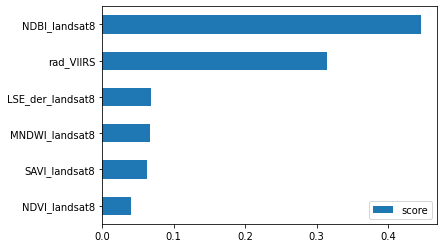

In [76]:
keys = ['rad_VIIRS','SAVI_landsat8','NDVI_landsat8','MNDWI_landsat8','NDBI_landsat8','LSE_der_landsat8']
values =xgclassifier.feature_importances_

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh')

In [ ]:
from sklearn.model_selection import cross_validate
X=dataset[['rad_VIIRS','SAVI_landsat8','MNDWI_landsat8','NDVI_landsat8','NDBI_landsat8','LSE_der_landsat8']]
y=dataset[['U_class']]
xgb_acc_jabodetabek=cross_validate(xgclassifier, X, y, cv=10,scoring={'acc':'accuracy','auc':'roc_auc','f1':'f1'})

In [ ]:
print('AUC: '+str(np.mean(xgb_acc_jabodetabek['test_auc'])))
print('Accuracy: '+str(np.mean(xgb_acc_jabodetabek['test_acc'])))
print('F1: '+str(np.mean(xgb_acc_jabodetabek['test_f1'])))

AUC: 0.9657754000000001
Accuracy: 0.9027499999999999
F1: 0.9046720478923828


### Get the result raster and export it

In [ ]:
class_2014_=xgclassifier.predict(minmax_.fit_transform(dataset_bands[['rad_VIIRS','SAVI_landsat8','NDVI_landsat8','MNDWI_landsat8','NDBI_landsat8','LSE_der_landsat8']]))

In [ ]:
confusion_matrix(dataset_bands[['U_class']],class_2014_)

array([[9521997,  307022],
       [ 817962, 1389430]])

In [ ]:
src=rasterio.open('/content/gdrive/My Drive/GeoPythonML_/compiled_GHSL_30_2014_.tif')
src_ = src.read(1)
array_class_2014=class_2014_.reshape(src_.shape[0],src_.shape[1]).astype(np.uint8)
profile = src.profile
profile.update(
        dtype=array_class_2014.dtype,
        count=1,
        compress='lzw')
with rasterio.open(
    '/content/gdrive/My Drive/GeoPythonML_/result.tif','w',**profile) as dst2:
    dst2.write(array_class_2014,1)
    dst2.close()

In [ ]:
from rasterio.plot import show
import matplotlib.pyplot as plt

In [ ]:
def classify_uclass(x):
  if x>=3:
    return 1
  else :
    return 0
classify_uclass=np.vectorize(classify_uclass)
data_raster= rasterio.open('/content/gdrive/My Drive/GeoPythonML_/compiled_GHSL_30_2014_.tif','r')
u_class=data_raster.read(1)
u_class=classify_uclass(u_class)
differences=u_class-array_class_2014

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


**Plot of Raster**

The left ones is GHSL class and the right ones is the classification result. White indicate the built up area

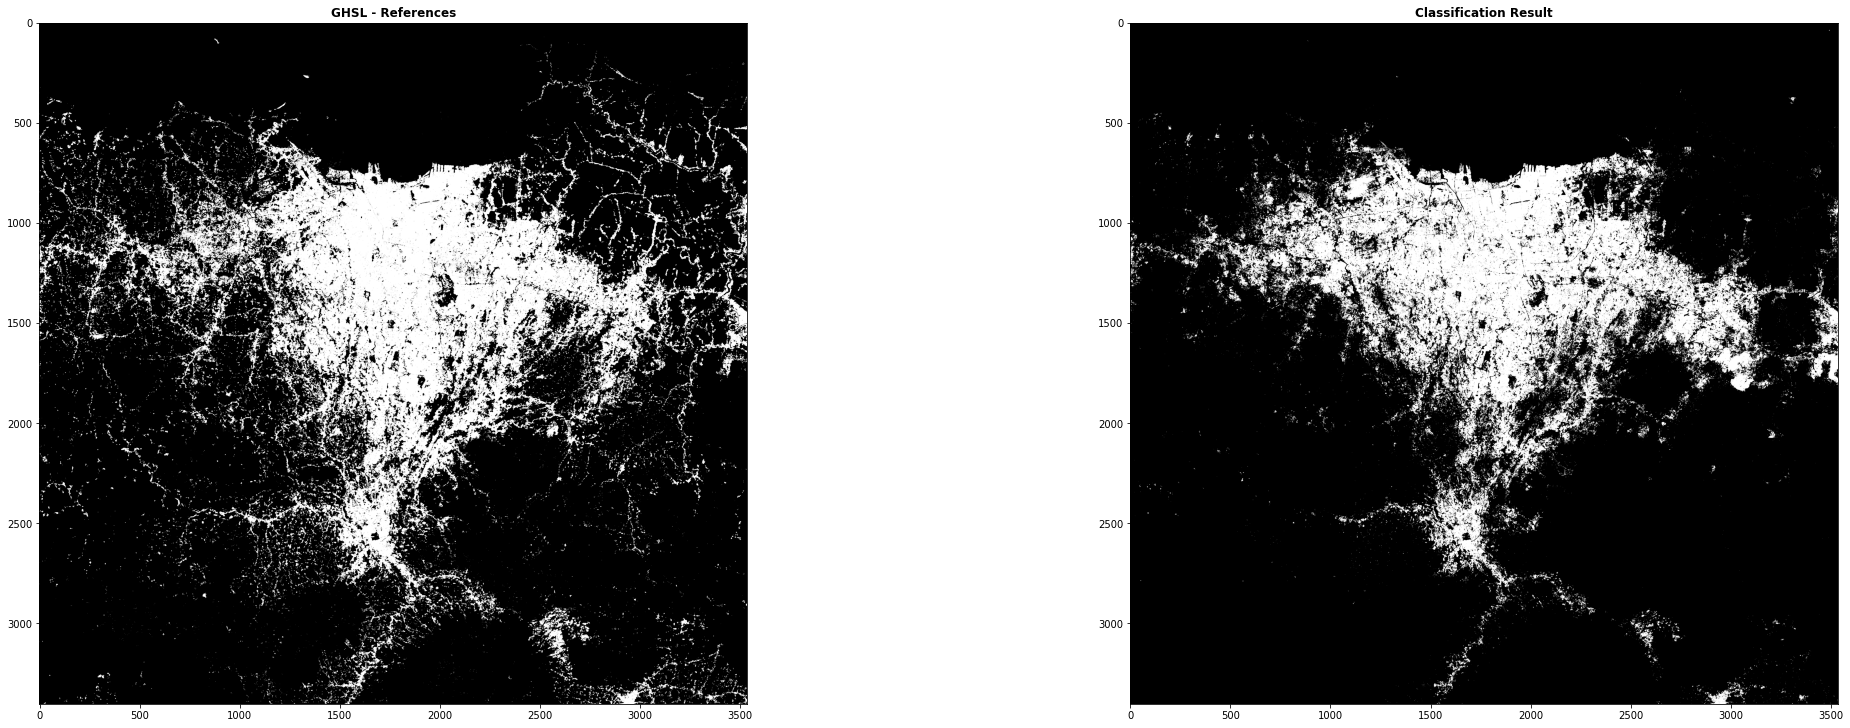

In [80]:
fig, (ax1,ax2) = plt.subplots(1, 2, constrained_layout=True,figsize=(30,10))
show(u_class,cmap='Greys_r',ax=ax1,title='GHSL - References')
show(array_class_2014,cmap='Greys_r',ax=ax2,title='Classification Result')

**Plot of Raster**

The grey color indicates no differences between references and the result. White indicate built up on references but the classfier classify non built up and the black is the opposite.

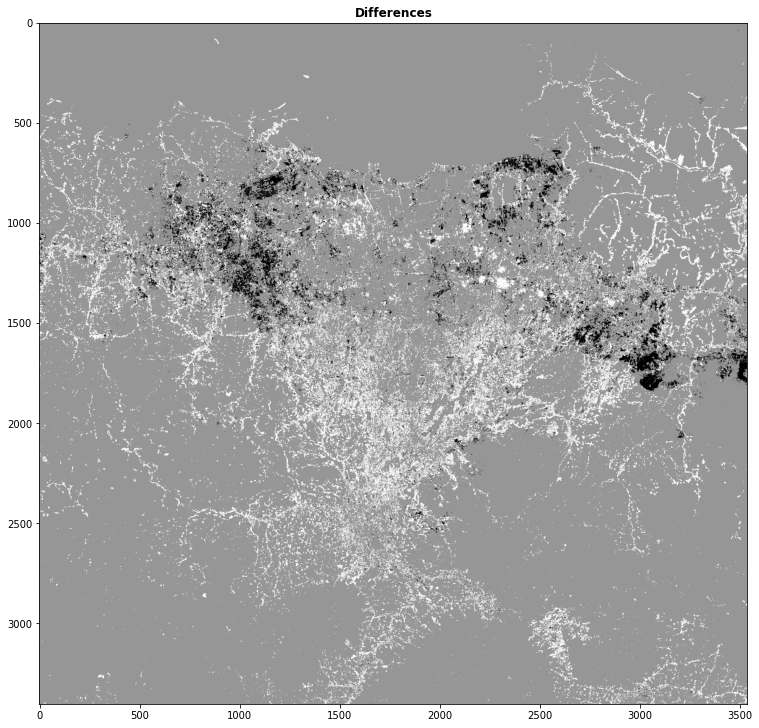

In [83]:
fig, ax1 = plt.subplots(1, 1, constrained_layout=True,figsize=(50,10))
show(differences,cmap='Greys_r',ax=ax1,title='Differences')